# Final Project
## Nicolas A Gort Freitas
## Semantic analysis and precision medicine

### Dependencies

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from mlxtend.plotting import plot_confusion_matrix

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from time import time
from string import punctuation
from collections import Counter
from copy import deepcopy

pd.set_option('max_colwidth',75)

## Sourced functions

In [14]:
# http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class ArrayCaster(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self

  def transform(self, data):
    return np.transpose(np.matrix(data))
    

#https://stackoverflow.com/questions/23455728/scikit-learn-balanced-subsampling
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Auxiliary functions

In [62]:
wnl = WordNetLemmatizer()
sw = stopwords.words('english')
def text_preprocessing(t, tokens=False):
    #lowercases
    text = t.lower()
    #remove punctuation
    text = re.sub(pattern=r'['+punctuation+']',repl=' ',string=text)
    
    #lemmatize
    #wnl = WordNetLemmatizer()
    words = [wnl.lemmatize(w) for w in word_tokenize(text) if w not in sw]
    
    if tokens:
        return words
    else:
        return " ".join(words)
    
def onecoldencoder(row):
    for c in y_test.columns:
        if row[c]==1:
            return int(c[-1])

In [17]:
def topic_identifier(words_from_chapters, n_topics=10,top_topics=10, dictionary = False):
    vec = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vec.fit_transform([" ".join(w) for w in words_from_chapters])
    vocab = vec.get_feature_names()

    count_matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

    lda = LatentDirichletAllocation(n_components=n_topics)
    lda.fit(count_matrix)

    topic_words = {}

        
    for topic, comp in enumerate(lda.components_):   
        word_idx = np.argsort(comp)[::-1][:top_topics]

        # store the words most relevant to the topic
        topic_words[topic] = [vocab[i] for i in word_idx]

    
    if dictionary:
            return topic_words
        
    for topic, words in topic_words.items():
        print('Topic: %d' % topic)
        print('  %s' % ', '.join(words))
        
    

### Importing training data 

In [26]:
training_variants = pd.read_csv('training_variants', skiprows = 1, names=['ID','Gene','Variation','Class']).set_index('ID')
training_text = pd.read_csv('training_text', sep = '\|\|', header = None, skiprows = 1, 
                            names = ['ID', 'Text'], engine = 'python', encoding = 'utf-8').set_index('ID')

training_data = training_text.dropna().join(training_variants)
X_train = training_data.loc[:,['Gene','Variation','Text']]
y_train = training_data.loc[:,'Class']

### Importing test data

In [27]:
test_variants = pd.read_csv('test_variants', skiprows = 1, names=['ID','Gene','Variation','Class']).set_index('ID')
test_text = pd.read_csv('test_text', sep = '\|\|', header = None, skiprows = 1, 
                            names = ['ID', 'Text'], engine = 'python', encoding = 'utf-8').set_index('ID')


test_data = test_text.dropna().join(test_variants)
X_test = test_data.loc[:,['Gene','Variation','Text']]

solutions = pd.read_csv('stage1_solution_filtered.csv')
X_test = solutions.join(X_test, how='left').loc[:,['ID','Gene','Variation','Text']].set_index('ID')
y_test = solutions.set_index('ID')

y_test = y_test.reset_index().iloc[:,1:].apply(onecoldencoder,1)
y_test.index = solutions.ID

### Preprocessing: 
* Deleting rows without text
* Removing punctuation, capitalization, stopwords

### Apply pre-processing

In [28]:
X_train.Text = X_train.Text.map(text_preprocessing)
X_test.Text = X_test.Text.map(text_preprocessing)

# What is each class related to?

# Supervised topic modeling through Latent Dirichlet Allocation

### Attempt 1: Classes as documents

In [29]:
text_by_class = training_data.groupby('Class').agg(lambda x : ' '.join(x).split(' ')).Text

In [69]:
topic_identifier(text_by_class, n_topics=9, top_topics=10)

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  vus, brca2, brct, odds, erbb2, vuss, smad2, mlh1, bard1, causality
Topic: 1
  alk, imatinib, gefitinib, brca2, tsc2, erbb2, vus, brct, smad3, d1
Topic: 2
  alk, brct, imatinib, gefitinib, brca2, ar, f3, ba, jak2, tsc2
Topic: 3
  tsc2, smad3, brct, smad2, brca2, sf3b1, idh1, tsc1, tgf, vhl
Topic: 4
  alk, imatinib, vus, brca2, gefitinib, brct, ar, d1, spop, smad2
Topic: 5
  imatinib, alk, gefitinib, brct, tsc2, nrf2, d1, ar, smad3, brca2
Topic: 6
  alk, imatinib, gefitinib, d1, nrf2, ba, f3, ar, jak2, erlotinib
Topic: 7
  imatinib, alk, gefitinib, ros1, d1, smo, erbb2, ret, fgfr3, gist
Topic: 8
  spop, p16ink4a, brct, tsc2, nf1, tsc1, smad3, p16, vhl, ar


Judging by these results, which include multiple repetitions across topics, we cannot use LDA to learn about the topic of each class.

### Attempt 2:  Genes as documents with one topic given each class

In [51]:
documents_per_class = ['']*9
for clss in range(1,10):
    documents_per_class[clss-1] = training_data.query('@training_joint.Class == {}'.format(clss)).groupby('Gene').agg(lambda x : ' '.join(x).split(' ')).Text


In [365]:
for clss in range(1,10):
    print('Class {} '.format(clss))
    topic_identifier(documents_per_class[clss], n_topics=1, top_topics=10)

Class 1 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  p53, fig, et, al, tsc2, binding, wild, cancer, mutants, tumor
Class 2 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  mutations, patients, mutation, et, al, figure, fig, kinase, egfr, tumor
Class 3 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  brca1, al, variants, et, cancer, alk, mtor, mutants, assay, domain
Class 4 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  pten, et, al, activity, fig, brca1, variants, cancer, binding, p53
Class 5 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  brca1, variants, functional, fig, vus, assays, domain, neutral, figure, binding
Class 6 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  brca1, variants, cells, fig, deleterious, binding, activity, dna, domain, kinase
Class 7 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  patients, fig, egfr, et, al, tumor, kit, domain, tumors, ras
Class 8 
Topic: 0


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


  al, et, figure, fig, genes, idh1, mutation, akt, h3, samples
Class 9 
Topic: 0
  mutations, mutant, sf3b1, figure, splicing, et, al, idh1, genes, 2hg


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


### Genes as documents (unsupervised) 

In [366]:
text_by_gene = training_data.groupby('Gene').agg(lambda x : ' '.join(x).split(' ')).Text
topic_identifier(text_by_gene, n_topics=9, top_topics=10)

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic: 0
  alk, kinase, fig, domain, met, activity, resistance, tumor, et, al
Topic: 1
  vhl, hif, pvhl, fig, 1α, complex, mutants, tumor, tric, et
Topic: 2
  variants, deleterious, variant, brca2, al, et, brca1, family, classification, mlh1
Topic: 3
  ras, pten, raf, activity, braf, al, et, fig, kinase, flt3
Topic: 4
  p53, et, al, fig, tumor, activity, tumors, mutants, cyclin, patients
Topic: 5
  brca1, variants, fig, brct, activity, assays, assay, breast, xrcc2, missense
Topic: 6
  spop, nrf2, al, fig, et, keap1, domain, ar, cul3, mutants
Topic: 7
  patients, fig, et, jak2, al, domain, kinase, egfr, catenin, mice
Topic: 8
  patients, egfr, kit, tumor, tumors, exon, al, et, fig, imatinib


## Multilabel Classification
### Are classes balanced?

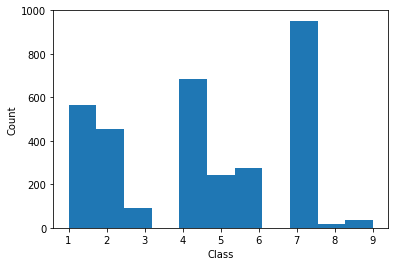

In [850]:
#class_counter = Counter(y_train)
plt.hist(y_train, bins = 11)
#plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Undersampling via Balanced undersampling

## Classification pipeline: Tfidvectorizer + Linear SVC (orig. test set)

In [44]:
y_pred_train_svc = best_svc.predict(X_train.Text)
y_pred_test_svc =  best_svc.predict(X_test.Text)



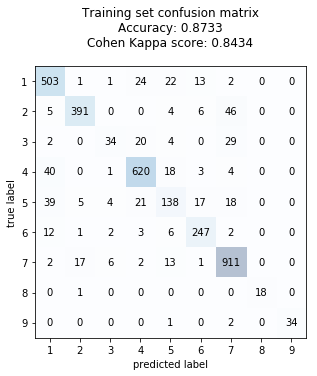

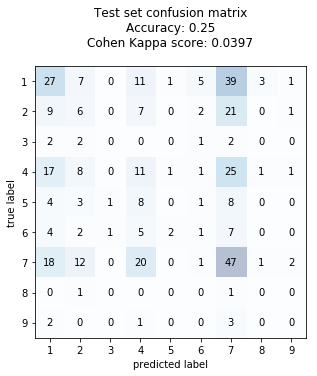

In [105]:
plot_confusion_matrix(confusion_matrix(y_train, y_pred_train_svc),
                      figsize=(5,5))
plt.title('Training set confusion matrix\nAccuracy: {}\nCohen Kappa score: {}'.format(
                 round(accuracy_score(y_pred=y_pred_train_svc,y_true=y_train),4), 
                  round(cohen_kappa_score(labels=range(1,10),y1 = y_pred_train_svc, y2 = y_train),4)))
plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))
#plt.show()

cm_net01_test = plot_confusion_matrix(confusion_matrix(y_test, y_pred_test_svc),
                      figsize=(5,5))
plt.title('Test set confusion matrix\nAccuracy: {}\nCohen Kappa score: {}'.format(
                 round(accuracy_score(y_pred=y_pred_test_svc,y_true=y_test),4), 
                  round(cohen_kappa_score(labels=range(1,10),y1 = y_pred_test_svc, y2 = y_test),4)))

plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))
plt.show()




# New split

In [108]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train)


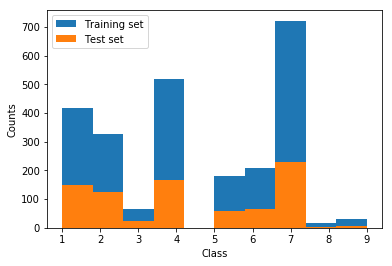

In [112]:
plt.hist(y_train_new, label='Training set')
plt.hist(y_test_new, label= 'Test set')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.legend()
plt.show()

# TfidfVectorizer + LinearSVC on new split

In [114]:
svc_pipeline = Pipeline([('vectorize', TfidfVectorizer()),        
                            ('classify', LinearSVC())])

svc_param_grid = {'vectorize__max_df' : (0.5,0.75,1),
                    'vectorize__ngram_range' : [(1, 1), (1, 2), (1, 3)],
                     'classify__C' : [0.1, 1, 10, 100],
                    }

svc_grid = GridSearchCV(svc_pipeline, scoring='f1_weighted', param_grid=svc_param_grid, verbose=3, n_jobs=3)

### Early stop due to RAM constraints, best hyperparameters manually fed into the pipeline 

In [116]:
svc_grid.fit(X_train_new.Text, y_train_new)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 
[CV] classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 
[CV] classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 
[CV]  classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.590733 -  16.6s
[CV]  classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.560979 -  16.3s
[CV] classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.575782 -  16.1s
[CV] classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV] classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2), score=0.585970 - 1.8min
[CV]  classify__C=0.1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2), s

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 1), score=0.220289 -  18.2s
[CV]  classify__C=0.1, vectorize__max_df=0.75, vectorize__ngram_range=(1, 3), score=0.585929 - 4.0min
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 1) 
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 2) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 1), score=0.234725 -  17.4s
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 2) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 1), score=0.254456 -  17.4s
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 2) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 2), score=0.221431 -  57.3s
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 3) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 2), score=0.243024 -  58.4s


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 2), score=0.254272 -  58.3s
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 3) 
[CV] classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 3) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 3), score=0.223314 - 2.1min
[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 3), score=0.247530 - 2.1min


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 16.5min


[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, vectorize__max_df=1, vectorize__ngram_range=(1, 3), score=0.264306 - 2.2min
[CV]  classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.605388 -  25.2s
[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 
[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.608912 -  22.4s
[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.617247 -  23.1s
[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2), score=0.602137 - 2.8min
[CV] classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 3) 
[CV]  classify__C=1, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2), score=0.613179 - 2.8min
[CV] classify__C=1, vectorize__max_d

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 1), score=0.265301 -  16.5s
[CV]  classify__C=1, vectorize__max_df=0.75, vectorize__ngram_range=(1, 3), score=0.632425 - 6.6min
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 1) 
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 2) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 1), score=0.267742 -  16.7s
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 2) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 1), score=0.278910 -  16.3s
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 2) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 2), score=0.273477 - 1.0min
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 3) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 2), score=0.278657 - 1.0min
[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 2), score=0.291142 -  59.7s
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 3) 
[CV] classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 3) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 3), score=0.274064 - 2.7min
[CV] classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 3), score=0.281923 - 2.7min
[CV] classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 
[CV]  classify__C=1, vectorize__max_df=1, vectorize__ngram_range=(1, 3), score=0.296808 - 2.6min
[CV] classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1) 
[CV]  classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.590511 -  38.2s
[CV] classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.603061 -  43.1s
[CV] classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 1), score=0.608685 -  39.6s
[CV] classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2) 
[CV]  classify__C=10, vectorize__max_df=0.5, vectorize__ngram_range=(1, 2), score=0.601919 -13.3min
[CV] classify__C=10, vectorize_

KeyboardInterrupt: 

In [117]:
# stopped Grid search early due to RAM and disk
# best pipeline:
# [CV]  classify__C=10, vectorize__max_df=0.75, vectorize__ngram_range=(1, 3), score=0.632425 -79.3min
best_svc = deepcopy(svc_pipeline)
best_svc.set_params(classify__C=1, vectorize__max_df=0.75,
                    vectorize__ngram_range=(1,3))

best_svc.fit(X_train_new.Text, y_train_new)

Pipeline(memory=None,
     steps=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=Tr...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [118]:
y_pred_train_new = best_svc.predict(X_train_new.Text)
y_pred_test_new =  best_svc.predict(X_test_new.Text)

## Performance metrics

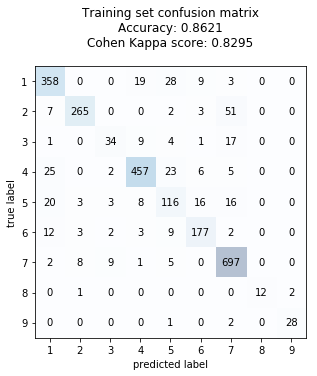

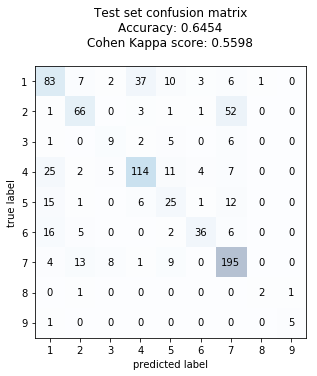

In [119]:
plot_confusion_matrix(confusion_matrix(y_train_new, y_pred_train_new),
                      figsize=(5,5))
plt.title('Training set confusion matrix\nAccuracy: {}\nCohen Kappa score: {}'.format(
                 round(accuracy_score(y_pred=y_pred_train_new,y_true=y_train_new),4), 
                  round(cohen_kappa_score(labels=range(1,10),y1 = y_pred_train_new, y2 = y_train_new),4)))
plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))
#plt.show()

plot_confusion_matrix(confusion_matrix(y_test_new, y_pred_test_new),
                      figsize=(5,5))
plt.title('Test set confusion matrix\nAccuracy: {}\nCohen Kappa score: {}'.format(
                 round(accuracy_score(y_pred=y_pred_test_new,y_true=y_test_new),4), 
                  round(cohen_kappa_score(labels=range(1,10),y1 = y_pred_test_new, y2 = y_test_new),4)))

plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))
plt.show()



In [127]:
print(f1_score(y_pred=y_pred_train_new,y_true=y_train_new, average='weighted'))
print(f1_score(y_pred=y_pred_test_new,y_true=y_test_new, average='weighted'))

0.8609671583960485
0.6415553561563578
